---
<h1><B> Fraud Analytics (CS6890)  </h1></B></center>

---

<table>
<tr> 
<td><h3> Assignment: </td>
<td><h3> 3 </td>
</tr>
<tr> 
<td><h3> Title : </td>
<td><h3> Trust Rank Assignment </td>
</tr>
<tr> 
<td><h3> Team Details : </td>
<td>

<table>
<tr>
<th> <h3> Name </th>
<th> <h3> Roll Number </th>
</tr>



<tr> 
<td><h5> Shreesh Gupta </td>
<td><h5> CS23MTECH12009 </td>
</tr>
<tr> 
<td><h5> Hrishikesh Hemke </td>
<td><h5> CS23MTECH14003 </td>
</tr>
<tr> 
<td><h5> Manan Patel </td>
<td><h5> CS23MTECH14006 </td>
</tr>
<tr> 
<td><h5> Yug Patel </td>
<td><h5> CS23MTECH14019 </td>
</tr>
<tr> 
<td><h5> Bhargav Patel </td>
<td><h5> CS23MTECH11026 </td>
</tr>

<table>



</td>
</tr>
<table>


In [ ]:
# Required libraries
!pip install pandas numpy matplotlib scikit-learn torch torch-geometric networkx gensim joblib node2vec scipy


In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load the datasets
payments_df = pd.read_csv('Payments.csv')
bad_senders_df = pd.read_csv('bad_sender.csv')

# Display the first few rows of each dataframe to understand their structure
payments_df.head(), bad_senders_df.head()


(   Sender  Receiver  Amount
 0    1309      1011  123051
 1    1309      1011  118406
 2    1309      1011  112456
 3    1309      1011  120593
 4    1309      1011  166396,
    Bad Sender
 0        1303
 1        1259
 2        1562
 3        1147
 4        1393)

In [3]:
print(len(payments_df), len(bad_senders_df))

130535 20


In [4]:
print(payments_df['Amount'].max(), payments_df['Amount'].min())

2124500 1501


In [5]:
unique_transactions = set()
for index, row in payments_df.iterrows():
    # Create a tuple of (Sender, Receiver)
    unique_transactions.add((row['Sender'], row['Receiver']))

print(len(unique_transactions))


5358


In [6]:
# Mark transactions involving bad senders
payments_df['Bad Sender'] = payments_df['Sender'].isin(bad_senders_df['Bad Sender'])

# Display a summary of transactions involving bad senders
bad_transactions_summary = payments_df['Bad Sender'].value_counts()
bad_transactions_summary


Bad Sender
False    117032
True      13503
Name: count, dtype: int64

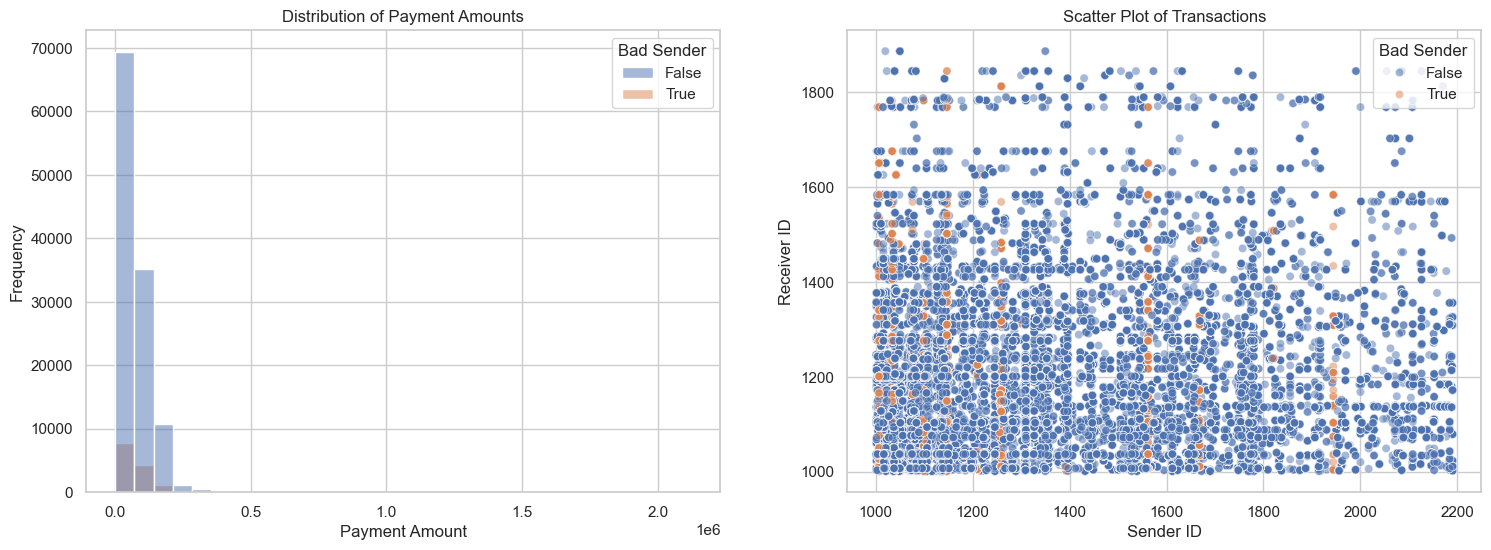

In [7]:


# Setting up the visual environment
sns.set(style="whitegrid")

# Create the plots
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Histogram of payment amounts
sns.histplot(data=payments_df, x='Amount', hue='Bad Sender', ax=ax[0], bins=30, kde=False)
ax[0].set_title('Distribution of Payment Amounts')
ax[0].set_xlabel('Payment Amount')
ax[0].set_ylabel('Frequency')

# Scatter plot of transactions
sns.scatterplot(data=payments_df, x='Sender', y='Receiver', hue='Bad Sender', ax=ax[1], alpha=0.5)
ax[1].set_title('Scatter Plot of Transactions')
ax[1].set_xlabel('Sender ID')
ax[1].set_ylabel('Receiver ID')

plt.show()


# TrustRank Algorithm Explanation

## Initialization

### Step 1: Initial Score Assignment
Every node $v$ in the graph $G$ is assigned an initial TrustRank score, $TR(v)$. The scores are uniformly distributed across all nodes:

$$ TR_0(v) = \frac{1}{N} $$

where $N$ is the total number of nodes in the graph.

## Personalization Vector

### Step 2: Personalization Vector Creation
A personalization vector $p$ is created to adjust initial scores based on node trustworthiness, specifically reducing the influence of known bad nodes:

$$
p(v) = 
\begin{cases} 
0.1 & \text{if } v \text{ is a bad node} \\
1 & \text{otherwise}
\end{cases}
$$

The vector is normalized to ensure that its elements sum to 1:

$$ p(v) = \frac{p(v)}{\sum_{u \in G} p(u)} $$

## Iterative Calculation

### Step 3: Iterative Score Update
The TrustRank score for each node is updated iteratively. At each iteration, the new score for a node $v$ is calculated based on the scores of its predecessors (nodes that point to $v$) adjusted by their transaction amounts as weights:

$$ TR_{i+1}(v) = (1 - d) \cdot p(v) + d \cdot \sum_{u \in P(v)} \frac{TR_i(u) \cdot w(u,v)}{\sum_{w \in S(u)} w(u,w)} $$

where:
- $P(v)$ is the set of predecessors of $v$,
- $S(u)$ is the set of successors of $u$,
- $w(u,v)$ is the weight of the edge from $u$ to $v$ (transaction amount),
- $d$ is the damping factor, typically set to 0.85, representing the probability of continuing the random walk through the network.

## Convergence

### Step 4: Convergence Check
The algorithm iterates until the TrustRank scores converge, which is typically determined by the total change in scores between iterations falling below a predefined threshold $\epsilon$:

$$ \sum_{v \in G} |TR_{i+1}(v) - TR_i(v)| < \epsilon $$

## Conclusion
This mathematical framework ensures that the TrustRank scores reflect not only the direct financial interactions between entities but also the broader network dynamics, particularly penalizing entities closely connected to known bad actors. The damping factor $d$ and the personalized initialization help to simulate a biased random walk that favors trustworthy nodes over others, effectively distinguishing between different levels of trustworthiness in the network.


In [8]:
def trustrank_stable(G, bad_nodes, damping_factor=0.85, max_iter=100, tol=1.0e-6):
    # Initialize trust scores uniformly
    n = G.number_of_nodes()
    trust_scores = {node: 1 / n for node in G.nodes()}
    
    # Initialize personalization vector, where bad nodes have lower initial score
    personalization = {node: (0.1 if node in bad_nodes else 1) for node in G.nodes()}
    total_personalization = sum(personalization.values())
    personalization = {node: p / total_personalization for node, p in personalization.items()}
    
    # Normalize initial trust scores based on personalization
    trust_scores = {node: trust_scores[node] * personalization[node] for node in G.nodes()}
    
    # Iterative calculation of TrustRank
    for _ in range(max_iter):
        prev_trust_scores = trust_scores.copy()
        # Each node gets a share of the score of its in-neighbors, adjusted by the damping factor
        for node in G.nodes():
            incoming_trust = sum(prev_trust_scores[neighbor] * G[neighbor][node]['weight'] / 
                                 sum(G[n][node]['weight'] for n in G.predecessors(node))
                                 for neighbor in G.predecessors(node))
            trust_scores[node] = (1 - damping_factor) * personalization[node] + damping_factor * incoming_trust
        
        # Check for convergence
        err = sum(abs(trust_scores[node] - prev_trust_scores[node]) for node in G.nodes())
        if err < n * tol:
            break
    
    return trust_scores


# Create the directed graph from the transactions data
G = nx.DiGraph()

# Add edges from the payment data; considering each transaction as an edge from sender to receiver
for index, row in payments_df.iterrows():
    # Use the payment amount as the weight of the edge
    G.add_edge(row['Sender'], row['Receiver'], weight=row['Amount'])

# Identifying bad nodes (from bad_senders_df)
bad_nodes = set(bad_senders_df['Bad Sender'].unique())

# Initialize node attributes (good = 1, bad = 0)
for node in G.nodes():
    G.nodes[node]['trust'] = 0 if node in bad_nodes else 1

# Compute TrustRank with stability adjustments
stable_trust_ranks = trustrank_stable(G, bad_nodes)
stable_trust_rank_results = pd.DataFrame(list(stable_trust_ranks.items()), columns=['Node', 'TrustRank'])
stable_trust_rank_results = stable_trust_rank_results.sort_values(by='TrustRank', ascending=False)
stable_trust_rank_results.head()


,Node,TrustRank
143,1058,0.000744
692,1325,0.000722
142,1019,0.000685
702,1567,0.000669
542,1041,0.000633


In [9]:
# Define a color, this will be used for the nodes in the graph.
# Here we're using a light blue color in RGB format, divided by 255 to use the 0-1 scale.
CLR = (255, 165, 0) 
CLR = [x/255 for x in CLR]

# A simple function to plot the graph using NetworkX
def plot_graph(graph):
    """A simple function to plot the graph using NetworkX."""
    # Set the color for each node. Here, all nodes will have the same color.
    node_colors = [CLR] * len(graph.nodes())
    
    # Set the figure size
    plt.figure(figsize=(10, 10))
    
    # Define the layout for the graph. You can experiment with different layouts to see which works best for your graph.
    pos = nx.kamada_kawai_layout(graph)
    
    # Draw the networkx graph -- nodes, edges, and labels.
    nx.draw_networkx_edges(graph, pos, alpha=0.5)
    nx.draw_networkx_nodes(graph, pos, node_color=node_colors, cmap='autumn_r', node_size=50)
    nx.draw_networkx_labels(graph, pos, font_size=8, font_color='black')
    
    # Turn off the axis, as they are not meaningful for this kind of plot.
    plt.axis('off')
    
    # Display the plot.
    plt.show()

c:\Users\gupta\anaconda3\envs\farudA\Lib\site-packages\networkx\drawing\nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


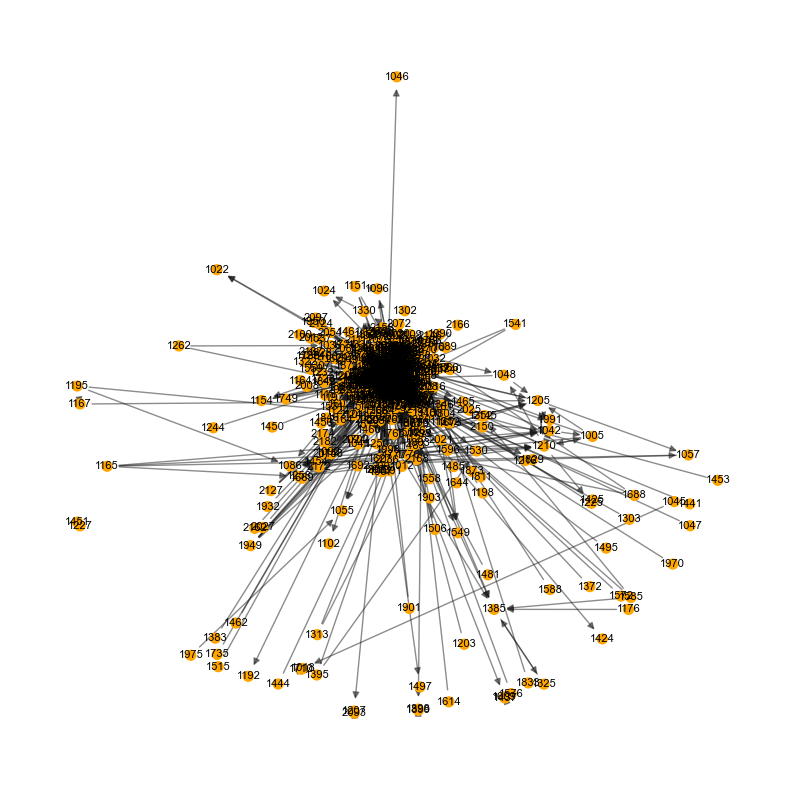

In [10]:
plot_graph(G)

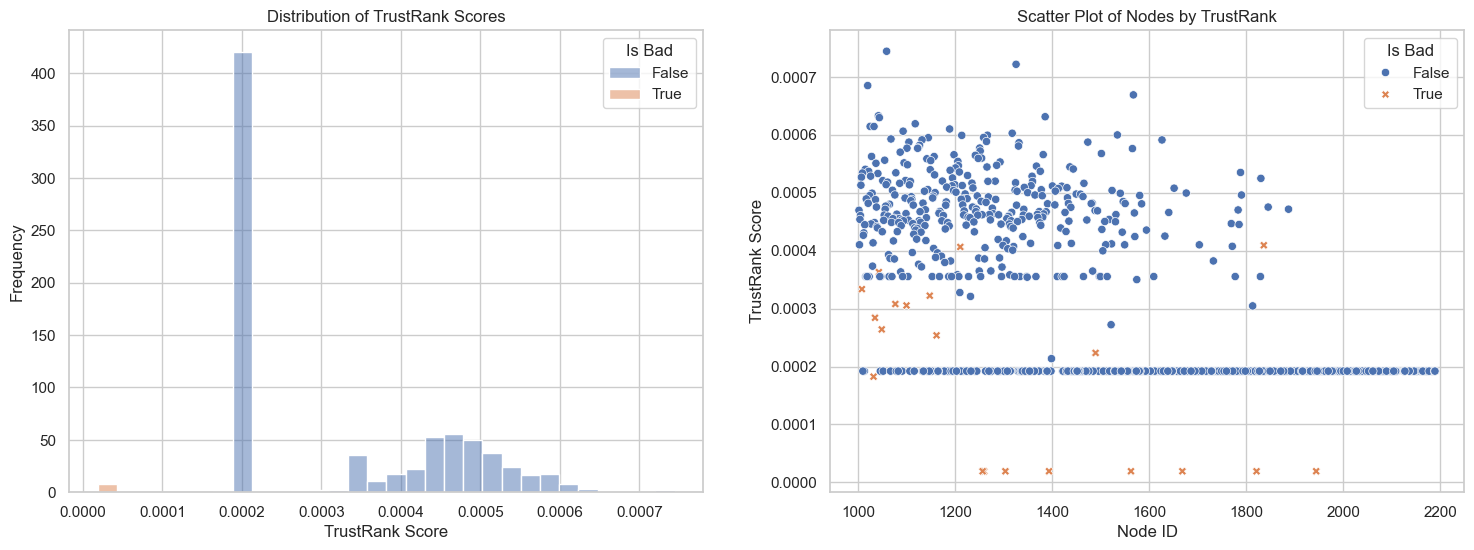

In [11]:
# Merge trust rank data with bad sender information for visualization
stable_trust_rank_results['Is Bad'] = stable_trust_rank_results['Node'].isin(bad_nodes)

# Setting up the visual environment
sns.set(style="whitegrid")

# Create the plots
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Distribution of TrustRank scores
sns.histplot(data=stable_trust_rank_results, x='TrustRank', hue='Is Bad', ax=ax[0], bins=30, kde=False)
ax[0].set_title('Distribution of TrustRank Scores')
ax[0].set_xlabel('TrustRank Score')
ax[0].set_ylabel('Frequency')

# Scatter plot of TrustRank scores
sns.scatterplot(data=stable_trust_rank_results, x='Node', y='TrustRank', hue='Is Bad', ax=ax[1], style='Is Bad', markers=['o', 'X'])
ax[1].set_title('Scatter Plot of Nodes by TrustRank')
ax[1].set_xlabel('Node ID')
ax[1].set_ylabel('TrustRank Score')

plt.show()


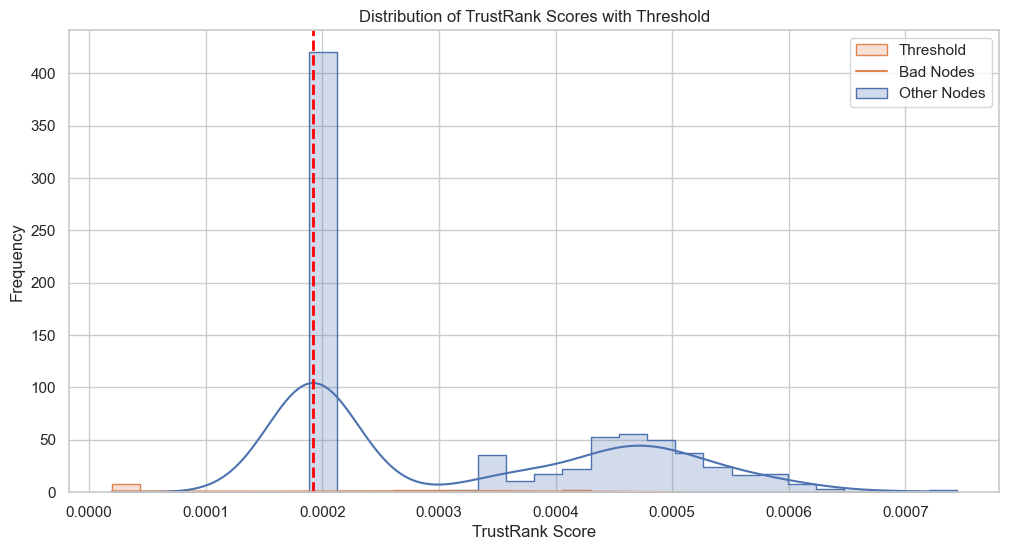

0.0001920614596670935

In [12]:
# Calculate the 10th percentile of the TrustRank scores
threshold = stable_trust_rank_results['TrustRank'].quantile(0.1)

# Visualize the threshold on the histogram
fig, ax = plt.subplots(figsize=(12, 6))

# Plot histogram with threshold line
sns.histplot(data=stable_trust_rank_results, x='TrustRank', hue='Is Bad', bins=30, kde=True, element="step", ax=ax)
ax.axvline(x=threshold, color='red', linestyle='--', linewidth=2)
ax.set_title('Distribution of TrustRank Scores with Threshold')
ax.set_xlabel('TrustRank Score')
ax.set_ylabel('Frequency')
ax.legend(['Threshold', 'Bad Nodes', 'Other Nodes'])

plt.show()

threshold


In [13]:
# Initial classification count based on provided bad senders list
initial_bad_nodes_count = len(bad_nodes)

# Post-TrustRank classification count based on the computed threshold
post_trustrank_bad_nodes_count = stable_trust_rank_results[stable_trust_rank_results['TrustRank'] <= threshold].shape[0]
total_nodes_count = stable_trust_rank_results.shape[0]

initial_bad_nodes_count, post_trustrank_bad_nodes_count, total_nodes_count


(20, 429, 799)

Here are the results:

- **Total Number of Nodes:** 799
- **Initially Classified as Bad Nodes:** 20 (based on the provided bad senders list)
- **Classified as Bad Nodes After TrustRank Calculation:** 429 (nodes with TrustRank scores below the threshold)


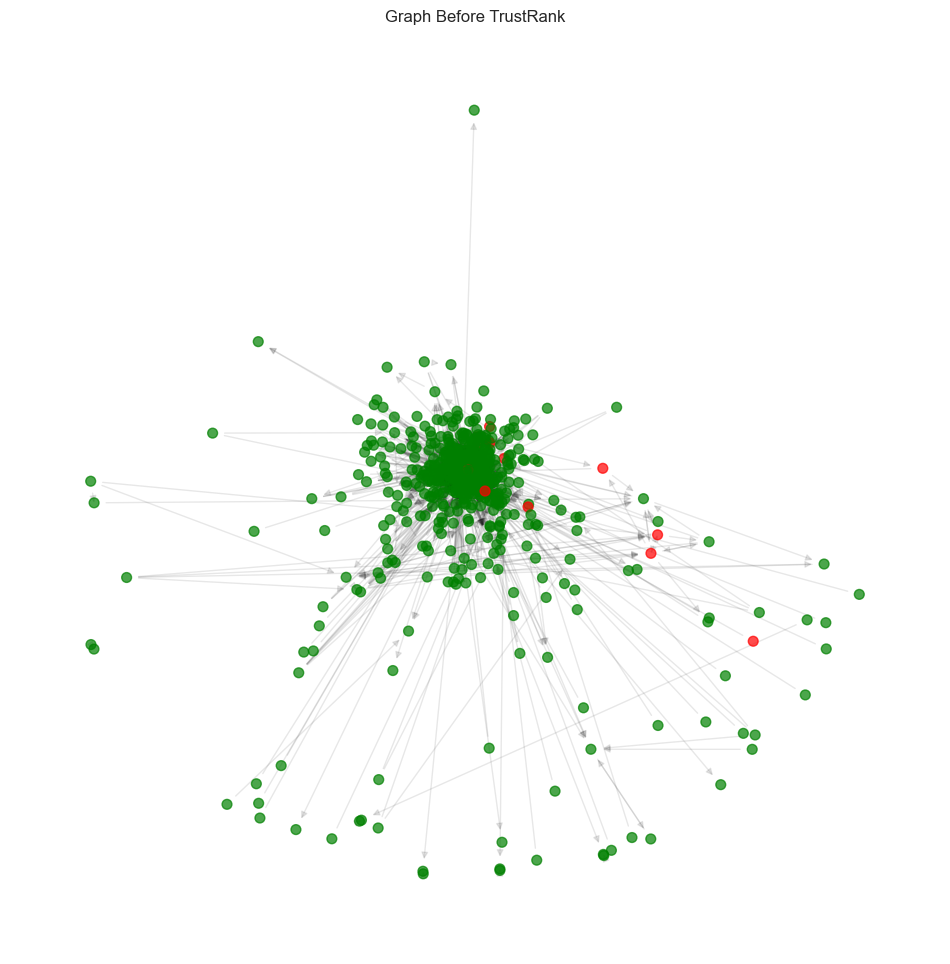

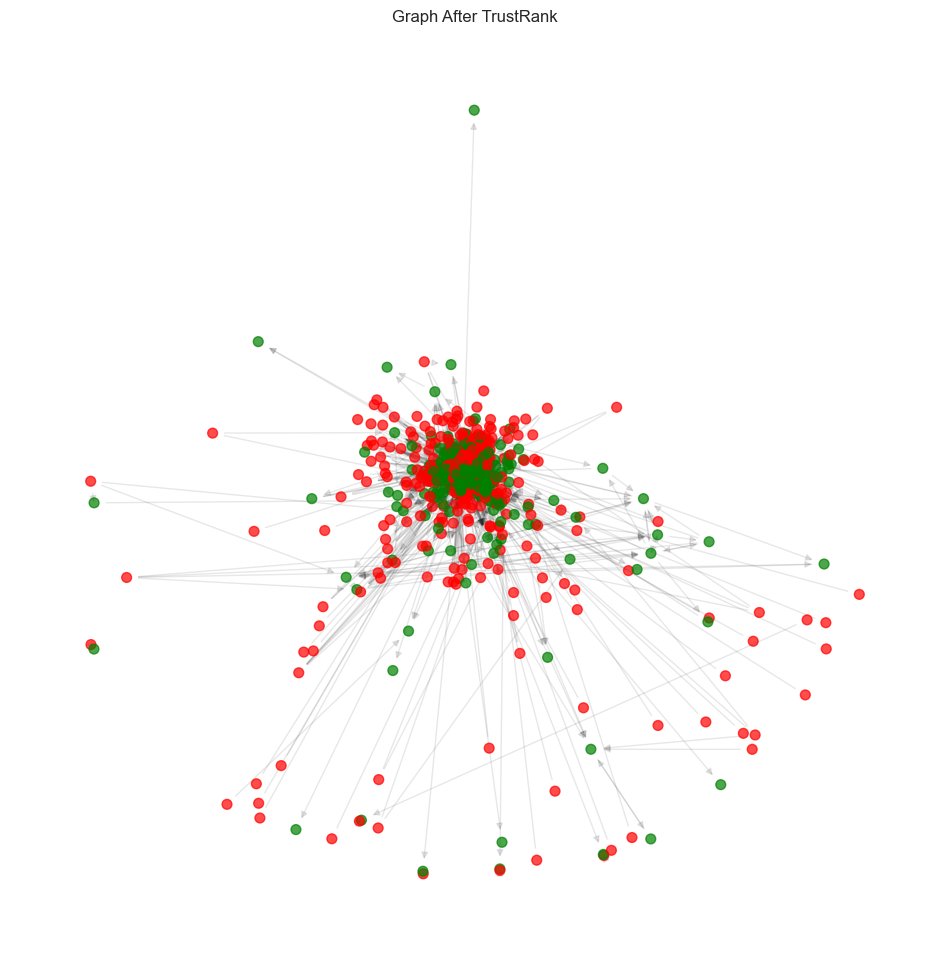

In [15]:
# Visualize the graph before applying TrustRank, using the initial bad senders list
def visualize_graph(G, pos, bad_nodes, title, trust_scores=None, threshold=None):
    plt.figure(figsize=(12, 12))
    # Determine node colors based on bad node classification
    if trust_scores is None:
        # Initial classification based on provided bad senders list
        node_colors = ['red' if node in bad_nodes else 'green' for node in G.nodes()]
    else:
        # Classification based on TrustRank scores
        node_colors = ['red' if trust_scores[node] <= threshold else 'green' for node in G.nodes()]

    # Node sizes can be uniform or based on TrustRank scores
    if trust_scores is None:
        node_sizes = [50 for _ in G.nodes()]  # uniform size if scores not provided
    else:
        # node_sizes = [trust_scores[node] * 5000 for node in G.nodes()]  # scaled by TrustRank scores
        node_sizes = [50 for _ in G.nodes()]  # uniform size if scores not provided

    # Draw nodes and edges
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.7)
    nx.draw_networkx_edges(G, pos, alpha=0.1)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Layout for visualizing the nodes
pos = nx.kamada_kawai_layout(G)

# Visualize the graph before TrustRank scores are applied
visualize_graph(G, pos, bad_nodes, "Graph Before TrustRank")

# Visualize the graph after applying TrustRank, using the computed TrustRank scores and threshold
visualize_graph(G, pos, bad_nodes, "Graph After TrustRank", trust_scores=stable_trust_ranks, threshold=threshold)


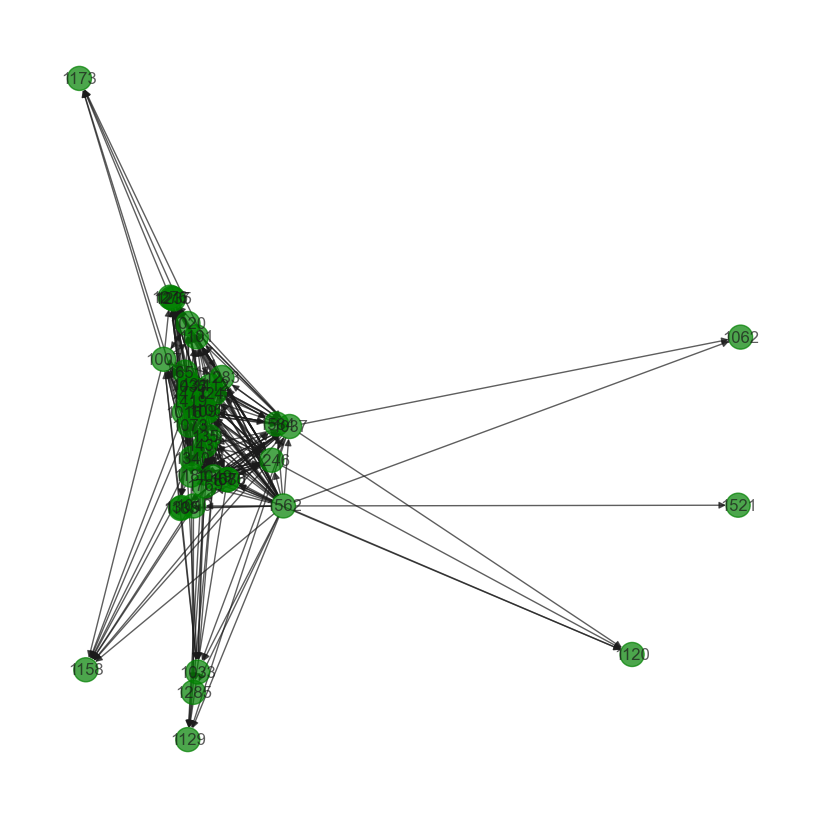

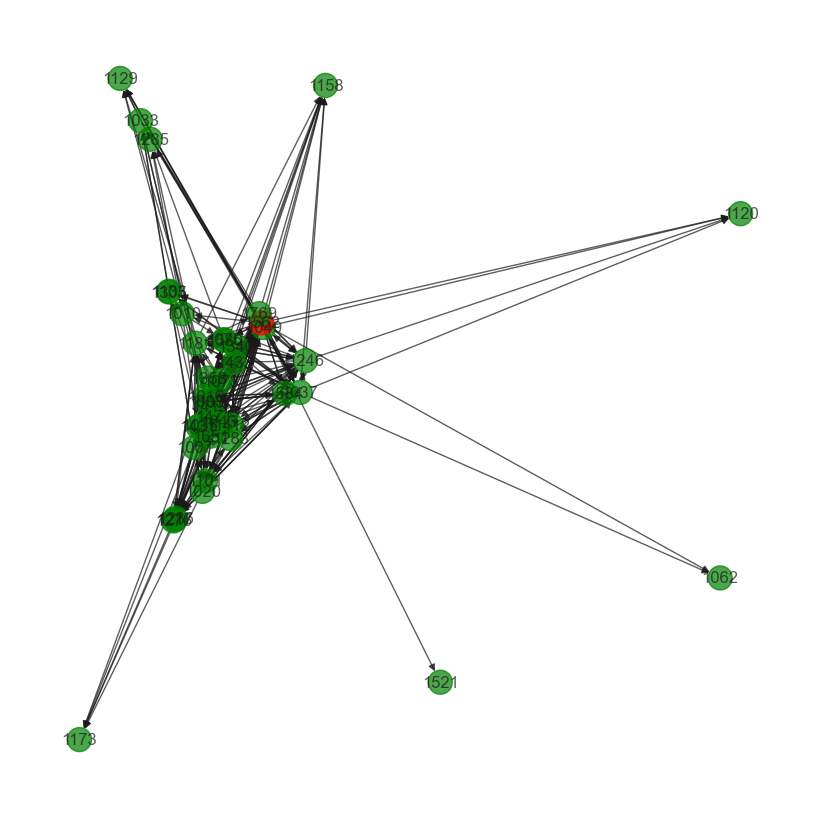

In [16]:
def visualize_subgraph(G, node_id, trust_scores=None, threshold=None):
    # Extract the subgraph for the specified node and its neighbors
    subgraph = G.subgraph([node_id] + list(G.neighbors(node_id)))
    
    # Determine the layout
    pos = nx.spring_layout(subgraph)
    
    # Determine the color of the nodes based on the TrustRank score
    node_colors = []
    for node in subgraph:
        if trust_scores and trust_scores[node] <= threshold:
            node_colors.append('red')  # Color for nodes below the TrustRank threshold
        else:
            node_colors.append('green')  # Color for nodes above the TrustRank threshold

    # Draw the subgraph
    plt.figure(figsize=(8, 8))
    nx.draw(subgraph, pos, node_color=node_colors, with_labels=True, alpha=0.7)
    plt.show()

# Use the function to visualize the subgraph before TrustRank scores are applied
selected_node_id =1562 #1259 #1944
visualize_subgraph(G, selected_node_id)

# Use the function to visualize the subgraph after TrustRank scores are applied
visualize_subgraph(G, selected_node_id, trust_scores=stable_trust_ranks, threshold=threshold)
